In [21]:
import numpy as np
from gr_pursuer.astar import astar2d
from gr_pursuer.agents.evader import Evader
from multigrid.envs.evader_pursuer import EvaderPursuerEnv

In [37]:
env = PursuerEnv(size=32, agent_view_size=5, render_mode='human')
# env.agents[0].view_size = 5
env.reset()

evader = Evader(env.agents[1], env.goal)
observations, infos = env.reset()
# observations = [{"grid": env.grid.state, "pos": agent.pos, "dir": agent.dir} 
#                    for agent in env.agents]

In [7]:
grid = observations[0]["grid"][:, :, 0]
grid

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

: 

In [6]:
env.agents[0].pos

(8, 4)

In [7]:
env.agents[0].pos

(8, 4)

In [8]:
env.agents[0].view_size

5

In [9]:
a = observations[0]["image"]
print(a)

[[[ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 8  1  0]
  [ 1  0  0]]

 [[10  1  1]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]]

 [[ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]]]


In [13]:
100 in a

False

In [10]:
print(np.unique(a))

[ 0  1  8 10]


In [3]:
grid = env.grid.state[:, :, 0]
cost = (grid==2).astype(int)*1000
path = astar2d(observations[1]["pos"], env.goal, cost)
path

[[8, 8],
 [7, 8],
 [6, 8],
 [5, 8],
 [4, 8],
 [3, 8],
 [2, 8],
 [2, 9],
 [2, 10],
 [2, 11],
 [2, 12],
 [2, 13],
 [2, 14]]

In [8]:
i = path.index([1, 8])

ValueError: [1, 8] is not in list

: 

In [4]:
observations[1]["pos"]

(8, 8)

In [7]:
obs = observations[0]

In [10]:
obs

{'image': array([[[ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0]],
 
        [[ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0]],
 
        [[ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0]],
 
        [[ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [10,  1,  1],
         [ 1,  0,  0],
         [ 1,  0,  0]],
 
        [[ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0]],
 
        [[ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0]],
 
       

In [14]:
print(str(env))

WGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWG
WG                            WG
WG                            WG
WG                            WG
WG                            WG
WG                            WG
WG      GG      VV            WG
WG                            WG
WG              VV            WG
WG                            WG
WG                            WG
WG                            WG
WG                          GGWG
WG            GG              WG
WG                            WG
WGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWG


In [17]:
from multigrid.core.constants import IDX_TO_OBJECT
IDX_TO_OBJECT

{0: <Type.unseen: 'unseen'>,
 1: <Type.empty: 'empty'>,
 2: <Type.wall: 'wall'>,
 3: <Type.floor: 'floor'>,
 4: <Type.door: 'door'>,
 5: <Type.key: 'key'>,
 6: <Type.ball: 'ball'>,
 7: <Type.box: 'box'>,
 8: <Type.goal: 'goal'>,
 9: <Type.lava: 'lava'>,
 10: <Type.agent: 'agent'>}

In [25]:
grid = env.grid.state[:, :, 0]
grid

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [29]:
cost = (grid==2).astype(int)*1000

In [24]:
env.agents[0].dir

<Direction.down: 1>

In [1]:
import numpy as np

In [6]:
class Type(str, IndexedEnum):
    """
    Enumeration of object types.
    """
    unseen = 'unseen'
    empty = 'empty'
    wall = 'wall'
    floor = 'floor'
    door = 'door'
    key = 'key'
    ball = 'ball'
    box = 'box'
    goal = 'goal'
    lava = 'lava'
    agent = 'agent'

class WorldObjMeta(type):
    """
    Metaclass for world objects.

    Each subclass is associated with a unique :class:`Type` enumeration value.

    By default, the type name is the class name (in lowercase), but this can be
    overridden by setting the `type_name` attribute in the class definition.
    Type names are dynamically added to the :class:`Type` enumeration
    if not already present.

    Examples
    --------
    >>> class A(WorldObj): pass
    >>> A().type
    <Type.a: 'a'>

    >>> class B(WorldObj): type_name = 'goal'
    >>> B().type
    <Type.goal: 'goal'>

    :meta private:
    """

    # Registry of object classes
    _TYPE_IDX_TO_CLASS = {}

    def __new__(meta, name, bases, class_dict):
        cls = super().__new__(meta, name, bases, class_dict)

        if name != 'WorldObj':
            type_name = class_dict.get('type_name', name.lower())

            # Add the object class name to the `Type` enumeration if not already present
            if type_name not in set(Type):
                Type.add_item(type_name, type_name)

            # Store the object class with its corresponding type index
            meta._TYPE_IDX_TO_CLASS[Type(type_name).to_index()] = cls

        return cls

WorldObjMeta()
# obj = np.zeros(3, dtype=int).view(1)
# obj


NameError: name 'IndexedEnum' is not defined

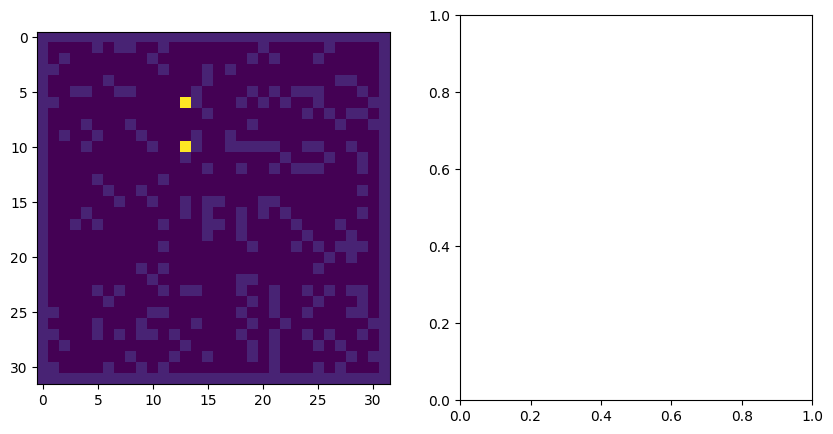

In [57]:
import random
import numpy as np
from time import sleep
import matplotlib.pyplot as plt




# center = size//2
# grid[center:center+1, center-4:center+4] = 0
# grid[center-4:center+4, center:center+1] = 0


def get_neighbours(coord, directions, size, cell_size):
    neighbours = [coord+dir for dir in directions[cell_size-1] 
                  if np.max(coord+dir) < size and np.min(coord+dir) >= 0]
    return neighbours

def unfill(grid, coord, size, cell_size):
    x1 = np.clip(coord[0], 1, size-1)
    x2 = np.clip(x1+cell_size, 1, size-1)
    y1 = np.clip(coord[1], 1, size-1)
    y2 = np.clip(y1+cell_size, 1, size-1)
    grid[x1:x2, y1:y2] = 0
    return grid

def position_agents(grid, init_sep, size):
    # Search for a random position where all the cells are unfilled in a initial_separation distance

    while True:
        #  np.where(grid == 0)
        row, col = np.where(grid == 0)
        idx = random.randint(0, len(row)-1)
        x, y = row[idx], col[idx]

        # Check if the col or row is empty
        if y+init_sep < size and (np.sum(grid[x, y:y+init_sep+1]) == 0):
            return [x, y], [x, y+init_sep]
        elif x+init_sep < size and (np.sum(grid[x:x+init_sep+1, y]) == 0):
            return [x, y], [x+init_sep, y]
        elif y-init_sep >= 0 and (np.sum(grid[x, y-init_sep:y]) == 0):
            return [x, y], [x, y-init_sep]
        elif x-init_sep >= 0 and (np.sum(grid[x-init_sep:x, y]) == 0):
            return [x, y], [x-init_sep, y]

directions = [[np.array([1, 0]), np.array([-1, 0]), np.array([0, 1]), np.array([0, -1])],
              [
                np.array([-1, 0]), np.array([-1, 1]), np.array([0, 2]), np.array([1, 2]), 
                np.array([2, 1]), np.array([2, 0]), np.array([0, -1]), np.array([1, -1])
               ]
              ]

size = 32
cell_size = 2
grid = np.ones((size, size), dtype=int)

#Choose 2 random points
start = np.random.randint(0, size//cell_size, 2)
grid = unfill(grid, start, size, cell_size)
explored = {tuple(start): 1}
queue = get_neighbours(start, directions, size, cell_size)

i = 0
while len(queue)>0:
    
    # idx = random.randint(0, len(queue)-1)
    idx = 3 if len(queue)>3 else 0
    cell = queue[idx]
    explored[tuple(cell)] = 1
    neighbours = get_neighbours(cell, directions, size, cell_size)
    filled_neighbours = [neighbour for neighbour in neighbours 
                         if grid[tuple(neighbour)] == 1]

    # The cell doesn't have 2 explored neighbours
    if ((cell_size==1) and (len(filled_neighbours) > 2) or (cell_size==2) and (len(filled_neighbours) > 2)):
        # grid[tuple(cell)] = 0
        grid = unfill(grid, cell, size, cell_size)
        queue += [neighbour for neighbour in filled_neighbours
                  if tuple(neighbour) not in explored]
        
    queue.pop(idx)
    # Change the cell size randomly
    cell_size = random.randint(1, 2) if cell[0]%2==0 and cell[1]%2==0 else 1

agent_pos, observer_pos = position_agents(grid, 4, size)
if grid[tuple(agent_pos)] == 1:
    print("Error: agent position is on a wall")
if grid[tuple(observer_pos)] == 1:
    print("Error: observer position is on a wall")

grid[tuple(agent_pos)] = 10
grid[tuple(observer_pos)] = 10

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(grid, interpolation='nearest')

In [13]:
grid[center:center+1, center-4:center]

array([[1, 0, 0, 0]])

In [12]:
center

16

In [16]:
# grid.save("grid.npy")
np.save("grid.npy", grid)

In [38]:
rows, cols = np.where(grid==1)
env.grid.state[rows, cols] = Wall()

: 

In [32]:
env.grid.state

array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [2, 5, 0],
        [2, 5, 0],
      

In [28]:
# from .world_object import Wall
from multigrid.core.world_object import Wall

env.grid.state


array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [2, 5, 0],
        [2, 5, 0],
      

In [66]:
[np.arange(0, 10, 1)//2 == 1, np.arange(0, 10, 1)//2 == 2]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 10

In [61]:
a = list(range(10))
[e//2 for e in a]

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

In [33]:
queue
# random.choice(len(queue))

[array([9, 3]), array([7, 3]), array([8, 4]), array([8, 2])]

In [41]:
# choose a ramdom number between 0 and len(queue)

idx = random.randint(0, 100)